In [233]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv("../datasets/Ruter_data.csv", delimiter=';')
data

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,10001-2020-06-10T15:10:00+02:00,10/06/2020,Viken,Nordøst,Lillestrøm,Brauterkrysset,Nordsnoveien,Lokal,Viken,100,1,16:23:18,16:23:48,16:10:00,16:10:00,151,2
5996,10010-2020-06-23T05:54:00+02:00,23/06/2020,Viken,Nordøst,Lillestrøm,Vestbygata,Bjørnsons gate,Lokal,Viken,100,0,06:00:32,06:00:40,05:59:00,05:59:00,151,2
5997,2007-2020-06-11T17:22:00+02:00,11/06/2020,Oslo,Indre By,Sagene,Torshovparken (mot Torshovparken),Torshov (mot Bentsebrua),Lokal,Oslo,20,1,17:42:43,17:43:10,17:32:00,17:32:00,106,3
5998,10004-2020-08-13T04:59:00+02:00,13/08/2020,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Grønland),Oslo gate (mot Grønland),Lokal,Viken,100,0,06:00:11,06:00:23,05:59:00,05:59:00,151,5


In [234]:
# We remove entries without an arrival time
data = data[data.Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra != ':']
df = data.reset_index(drop=True)
df.shape

(5950, 17)

We select only rows containing bus of type 100

In [235]:
df = df[cut_data.Linjenavn == '100'].reset_index(drop=True)

With regression we need all axes to be numerical values, date therefore needs to be changed into a more workable datatype. We will change it to be represented as the number of days since the first entry in the set, first of june 2020 being the 0'th day.

In [236]:
genesis = pd.Timestamp(day = 1, month = 6, year = 2020)

date_to_dmy = lambda date : tuple(map(int, date.split('/')))

def days_since_genesis(date) :
    global genesis
    dmy = date_to_dmy(date)
    time = pd.Timestamp(day = dmy[0], month = dmy[1], year = dmy[2])
    return (time - genesis).days

df['Day'] = df['Dato'].apply(days_since_genesis)

df = df[['Day', 'Passasjerer_Ombord']].groupby(by='Day').mean()
df

,Passasjerer_Ombord
Day,
0,5.666667
1,6.333333
2,10.000000
3,7.375000
4,1.500000
...,...
86,15.400000
87,5.714286
88,5.714286


### Fitting

In [237]:
x = df.index.values.reshape(-1, 1)
y = df.iloc[:, -1]

In [245]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_reg = PolynomialFeatures(degree = 6)
x_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(x_poly, y)

array([6.04089961])

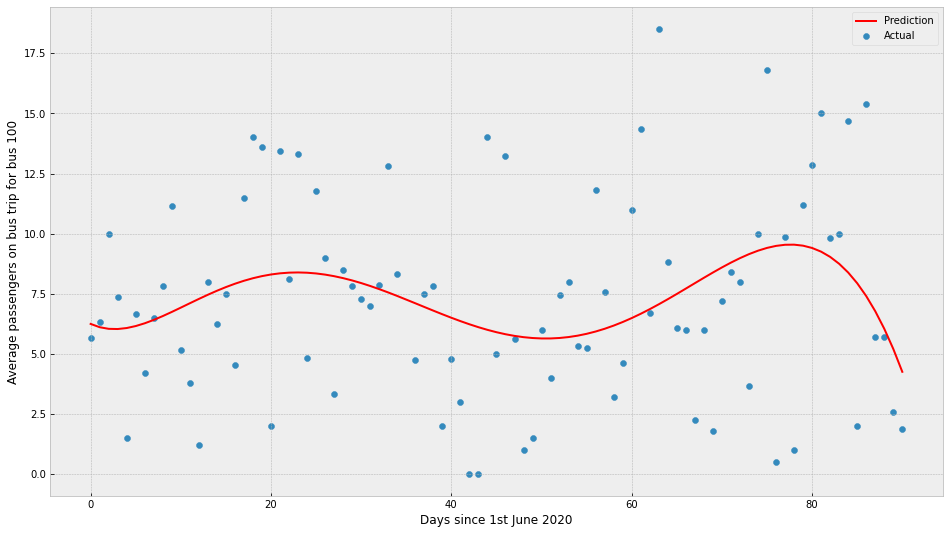

In [250]:
plt.style.use('bmh')
plt.figure(figsize=(16, 9))
plt.xlabel('Days since 1st June 2020')
plt.ylabel('Average passengers on bus trip for bus 100')
plt.scatter(x, y)
plt.plot(x, pol_reg.predict(x_poly), color='Red')
plt.legend(['Prediction', 'Actual'])
plt.show()

In [251]:

pol_reg.predict(poly_reg.fit_transform([[36]]))

array([7.10417435])

In [254]:
def predict(date) :
    day = days_since_genesis(date)
    return pol_reg.predict(poly_reg.fit_transform(([[day]])))

In [256]:
predict('10/10/2020')

array([-210.53722375])